<a href="https://colab.research.google.com/github/KenjiNakagawa/RL-public/blob/master/DQNSimple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import numpy as np
from collections import deque
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.animation as animation
import matplotlib.pyplot as plt


class CatchBall:
    def __init__(self):
        # parameters
#         self.name = os.path.splitext(os.path.basename(__file__))[0]
        self.name = "Env"
        self.screen_n_rows = 8
        self.screen_n_cols = 8
        self.player_length = 3
        self.enable_actions = (0, 1, 2)
        self.frame_rate = 5

        # variables
        self.reset()

    def update(self, action):
        """
        action:
            0: do nothing
            1: move left
            2: move right
        """
        # update player position
        if action == self.enable_actions[1]:
            # move left
            self.player_col = max(0, self.player_col - 1)
        elif action == self.enable_actions[2]:
            # move right
            self.player_col = min(self.player_col + 1, self.screen_n_cols - self.player_length)
        else:
            # do nothing
            pass

        # update ball position
        self.ball_row += 1

        # collision detection
        self.reward = 0
        self.terminal = False
        if self.ball_row == self.screen_n_rows - 1:
            self.terminal = True
            if self.player_col <= self.ball_col < self.player_col + self.player_length:
                # catch
                self.reward = 1
            else:
                # drop
                self.reward = -1

    def draw(self):
        # reset screen
        self.screen = np.zeros((self.screen_n_rows, self.screen_n_cols))

        # draw player
        self.screen[self.player_row, self.player_col:self.player_col + self.player_length] = 1

        # draw ball
        self.screen[self.ball_row, self.ball_col] = 1

    def observe(self):
        self.draw()
        return self.screen, self.reward, self.terminal

    def execute_action(self, action):
        self.update(action)

    def reset(self):
        # reset player position
        self.player_row = self.screen_n_rows - 1
        self.player_col = np.random.randint(self.screen_n_cols - self.player_length)

        # reset ball position
        self.ball_row = 0
        self.ball_col = np.random.randint(self.screen_n_cols)

        # reset other variables
        self.reward = 0
        self.terminal = False


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
class DQNAgent:
    """
    Multi Layer Perceptron with Experience Replay
    """

    def __init__(self, enable_actions, environment_name):
        # parameters
#         self.name = os.path.splitext(os.path.basename(__file__))[0]
        self.name = "Agent"
        self.environment_name = environment_name
        self.enable_actions = enable_actions
        self.n_actions = len(self.enable_actions)
        self.minibatch_size = 32
        self.replay_memory_size = 1000
        self.learning_rate = 0.001
        self.discount_factor = 0.9
        self.exploration = 0.1
        self.model_dir = "models"
        self.model_name = "{}.ckpt".format(self.environment_name)

        # replay memory
        self.D = deque(maxlen=self.replay_memory_size)

        # model
        self.init_model()

        # variables
        self.current_loss = 0.0

    def init_model(self):
        tf.compat.v1.disable_eager_execution()

        # input layer (8 x 8)
        self.x = tf.compat.v1.placeholder(tf.float32, [None, 8, 8])
        
        # flatten (64)
        x_flat = tf.reshape(self.x, [-1, 64])

        # fully connected layer (32)
        W_fc1 = tf.Variable(tf.truncated_normal([64, 64], stddev=0.01))
        b_fc1 = tf.Variable(tf.zeros([64]))
        h_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

        # output layer (n_actions)
        W_out = tf.Variable(tf.truncated_normal([64, self.n_actions], stddev=0.01))
        b_out = tf.Variable(tf.zeros([self.n_actions]))
        self.y = tf.matmul(h_fc1, W_out) + b_out

        # loss function
        self.y_ = tf.compat.v1.placeholder(tf.float32, [None, self.n_actions])
        self.loss = tf.reduce_mean(tf.square(self.y_ - self.y))

        # train operation
        optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.training = optimizer.minimize(self.loss)

        # saver
        self.saver = tf.train.Saver()

        # session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def Q_values(self, state):
        # Q(state, action) of all actions
        return self.sess.run(self.y, feed_dict={self.x: [state]})[0]

    def select_action(self, state, epsilon):
        if np.random.rand() <= epsilon:
            # random
            return np.random.choice(self.enable_actions)
        else:
            # max_action Q(state, action)
            return self.enable_actions[np.argmax(self.Q_values(state))]

    def store_experience(self, state, action, reward, state_1, terminal):
        self.D.append((state, action, reward, state_1, terminal))

    def experience_replay(self):
        state_minibatch = []
        y_minibatch = []

        # sample random minibatch
        minibatch_size = min(len(self.D), self.minibatch_size)
        minibatch_indexes = np.random.randint(0, len(self.D), minibatch_size)

        for j in minibatch_indexes:
            state_j, action_j, reward_j, state_j_1, terminal = self.D[j]
            action_j_index = self.enable_actions.index(action_j)

            y_j = self.Q_values(state_j)

            if terminal:
                y_j[action_j_index] = reward_j
            else:
                # reward_j + gamma * max_action' Q(state', action')
                y_j[action_j_index] = reward_j + self.discount_factor * np.max(self.Q_values(state_j_1))  # NOQA

            state_minibatch.append(state_j)
            y_minibatch.append(y_j)

        # training
        self.sess.run(self.training, feed_dict={self.x: state_minibatch, self.y_: y_minibatch})

        # for log
        self.current_loss = self.sess.run(self.loss, feed_dict={self.x: state_minibatch, self.y_: y_minibatch})

    def load_model(self, model_path=None):
        if model_path:
            # load from model_path
            self.saver.restore(self.sess, model_path)
        else:
            # load from checkpoint
            checkpoint = tf.train.get_checkpoint_state(self.model_dir)
            if checkpoint and checkpoint.model_checkpoint_path:
                self.saver.restore(self.sess, checkpoint.model_checkpoint_path)

    def save_model(self):
        self.saver.save(self.sess, os.path.join(self.model_dir, self.model_name))


In [7]:
if __name__ == "__main__":
    # parameters
    n_epochs = 50

    # environment, agent
    env = CatchBall()
    agent = DQNAgent(env.enable_actions, env.name)

    # variables
    win = 0

    for e in range(n_epochs):
        # reset
        frame = 0
        loss = 0.0
        Q_max = 0.0
        env.reset()
        state_t_1, reward_t, terminal = env.observe()

        while not terminal:
            state_t = state_t_1

            # execute action in environment
            action_t = agent.select_action(state_t, agent.exploration)
            env.execute_action(action_t)

            # observe environment
            state_t_1, reward_t, terminal = env.observe()

            # store experience
            agent.store_experience(state_t, action_t, reward_t, state_t_1, terminal)

            # experience replay
            agent.experience_replay()

            # for log
            frame += 1
            loss += agent.current_loss
            Q_max += np.max(agent.Q_values(state_t))
            if reward_t == 1:
                win += 1

        print("EPOCH: {:03d}/{:03d} | WIN: {:03d} | LOSS: {:.4f} | Q_MAX: {:.4f}".format(
            e, n_epochs - 1, win, loss / frame, Q_max / frame))

    # save model
    agent.save_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
EPOCH: 000/049 | WIN: 001 | LOSS: 0.0068 | Q_MAX: -0.0002
EPOCH: 001/049 | WIN: 001 | LOSS: 0.0456 | Q_MAX: 0.0009
EPOCH: 002/049 | WIN: 001 | LOSS: 0.0500 | Q_MAX: 0.0006
EPOCH: 003/049 | WIN: 001 | LOSS: 0.0342 | Q_MAX: 0.0005
EPOCH: 004/049 | WIN: 001 | LOSS: 0.0490 | Q_MAX: -0.0001
EPOCH: 005/049 | WIN: 002 | LOSS: 0.0371 | Q_MAX: -0.0002
EPOCH: 006/049 | WIN: 002 | LOSS: 0.0575 | Q_MAX: 0.0012
EPOCH: 007/049 | WIN: 002 | LOSS: 0.0532 | Q_MAX: 0.0021
EPOCH: 008/049 | WIN: 002 | LOSS: 0.0649 | Q_MAX: 0.0015
EPOCH: 009/049 | WIN: 002 | LOSS: 0.0543 | Q_MAX: -0.0003
EPOCH: 010/049 | WIN: 002 | LOSS: 0.0496 | Q_MAX: -0.0013
EPOCH: 011/049 | WIN: 002 | LOSS: 0.0399 | Q_MAX: -0.0043
EPOCH: 012/049 | WIN: 002 | LOSS: 0.0482 | Q_MAX: -0.0090
EPOCH: 013/049 | WIN: 002 | LOSS: 0.0511 | Q_MAX: -0.0150
EPOCH: 014/049 | WIN: 003 | LOSS: 0.0485 | Q_MAX: -0.0182
EPOCH: 015/049 | W

WIN: 001/001 (100.0%)
WIN: 001/002 (50.0%)
WIN: 001/003 (33.3%)
WIN: 002/004 (50.0%)
WIN: 002/005 (40.0%)
WIN: 003/006 (50.0%)
WIN: 004/007 (57.1%)
WIN: 005/008 (62.5%)
WIN: 005/009 (55.6%)
WIN: 006/010 (60.0%)
WIN: 006/011 (54.5%)
WIN: 006/012 (50.0%)


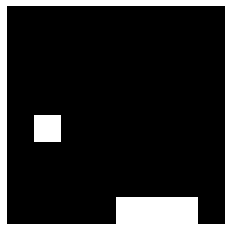

In [8]:
def init():
    img.set_array(state_t_1)
    plt.axis("off")
    return img,


def animate(step):
    global win, lose
    global state_t_1, reward_t, terminal

    if terminal:
        env.reset()

        # for log
        if reward_t == 1:
            win += 1
        elif reward_t == -1:
            lose += 1

        print("WIN: {:03d}/{:03d} ({:.1f}%)".format(win, win + lose, 100 * win / (win + lose)))

    else:
        state_t = state_t_1

        # execute action in environment
        action_t = agent.select_action(state_t, 0.0)
        env.execute_action(action_t)

    # observe environment
    state_t_1, reward_t, terminal = env.observe()

    # animate
    img.set_array(state_t_1)
    plt.axis("off")
    return img,

env = CatchBall()
# variables
win, lose = 0, 0
state_t_1, reward_t, terminal = env.observe()

# animate
fig = plt.figure(figsize=(env.screen_n_rows / 2, env.screen_n_cols / 2))
fig.canvas.set_window_title("{}-{}".format(env.name, agent.name))
img = plt.imshow(state_t_1, interpolation="none", cmap="gray")
ani = animation.FuncAnimation(fig, animate, init_func=init, interval=(1000 / env.frame_rate), blit=True)

w = animation.PillowWriter(fps=20)
ani.save('animation_test.gif', writer=w)

In [9]:
tf.__version__

'2.2.0'